<div align='center'><font size='20'>气动数据库的建立</font></div>
<div align='center'><font size='5'>飞行仿真原理大作业</font></div>

<div align='center'><font size='2'> (按学号排列)  周长威 包晨宇 吴哲铭 胡天辰 孙赵轩</font></div>

---

[toc]

0. 项目简介
1. 气动曲线图像数据读取的研究
2. 与Sqlite3数据库的交互访问
3. 离散数据点的插值连续化分析
4. 实例展示

---

---

# 0.项目简介

在飞行仿真中，为了达到仿真效果与真机一致，需要用到大量的气动参数。但是受制于仿真的成本，不可能在现实生活中客观地造出与实际飞机一致的模型，并用传感器实时获取气动参数——因此将已经用实验获取的气动参数，存入数据库中，在仿真时实时访问得到相应的输入输出结果是一个较好的处理方法。

但由于现役飞机大部分气动参数来源于国外，且一些较老的飞机气动参数是由曲线图给出的。如下图为地面效应系数与飞行马赫数关系曲线图： 

<div align="center"><img src="GroundEffectK.png" width=40%></div>

其曲线图具有如下不便于读取的特点：

- 给出的曲线图不能直接化成离散数据点
- 给出的曲线图往往是影印的，数据图像模糊
- 影印版本的数据在扫描时有旋转、翘曲的畸变，使得数据点的对应容易出现问题
- 一张曲线图上有多族曲线，难以分辨



针对上述问题，我们小组尽力尝试了一些算法，能够解决一些气动参数问题。整个工作流程大致如下：

1. 从某一给定的曲线图上，将曲线读取，并化成两行对应的离散数据点$x,y$
2. 与Sqlite3建立访问，将上述的离散数据点$x,y$存储入数据库中并保存
3. 建立函数库$y=f(x)$，在调用该曲线的对应函数式$f$时，读取数据库中已有的$x,y$数据，并给出输入值$x_{in}$的插值输出值

因而整个项目共有三个部分:

1. 气动曲线图像数据读取的研究
2. 与Sqlite3数据库的交互访问
3. 离散数据点的插值连续化分析

下面我们组将对于我们编写的函数与流程进行报告与分析，并在最后给第4部分出实例。

---

---

# 1. 气动曲线图像数据读取的研究

第一部分的输入(input)为：
- 图片
- 人工从曲线上读取的参数

第一部分的输出(output)为：
- 一组$x,y$对应的离散数据点


---

## 1.1. 理论分析

---

### 1.1.1. 图像预处理

图片的数据往往是一个$3\times m \times n$的矩阵，其中3表示的是图像的RGB颜色，m规定为图像的纵向行数，n规定为图像的横向列数。例如我们用opencv读取一张经典图片lena图，并显示它的尺寸信息：

<div align="center"><img src="lena.jpg" width=80%></div>

(其中opencv是一个跨平台图像处理工具，其在python中的安装可以在bash中输入以下命令进行安装)：
```bash
pip install opencv-python
```

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

size of this picture is:  (810, 1440, 3) 
 origin picture:


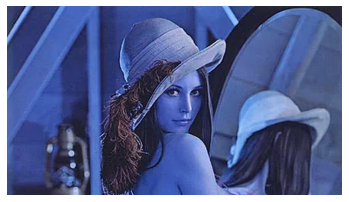

In [2]:
pic = cv.imread('lena.jpg') #利用opencv读取图像
mat = np.array(pic) #数组化
print('size of this picture is: ',mat.shape,'\n origin picture:')
plt.imshow(mat)
plt.axis('off')
plt.show()

可见这个图片是一个三通道的$810\times 1440$的三维数组，不是很方便处理。但是在opencv中有一个处理“图像灰度化”，可以将一个三维RGB数组投射到灰度值上，形成一个纯粹的$m\times n$矩阵,并且这个矩阵中存储的数值为0(黑)到255(白)：

size of the gray picture is :  (810, 1440) 
 gray pic :


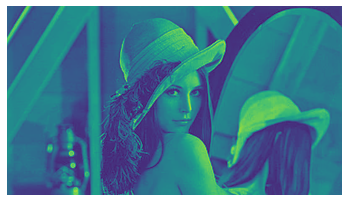

[[ 78  78  78 ...  51  51  51]
 [ 78  78  78 ...  51  51  51]
 [ 78  78  78 ...  51  51  51]
 ...
 [ 88  88  88 ...  95  96  97]
 [ 89  88  87 ...  99 100 100]
 [ 89  88  87 ...  99 100 100]]


In [3]:
gray = cv.cvtColor(pic , cv.COLOR_BGR2GRAY) #灰度化
gray = np.array(gray)
print('size of the gray picture is : ',gray.shape,'\n gray pic :')
plt.imshow(gray)
plt.axis('off')
plt.show()
print(gray)

此时容易发现每个像素点对应一个灰度值，为了统一各点的值，可以将其二值化进行处理，化成仅有两个值的情形：

binary pic :


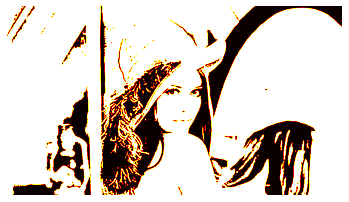

[[110 110 110 ...   0   0   0]
 [110 110 110 ...   0   0   0]
 [110 110 110 ...   0   0   0]
 ...
 [110 110 110 ... 110 110 110]
 [110 110 110 ... 110 110 110]
 [110 110 110 ... 110 110 110]]


In [4]:
retval , binary = cv.threshold(gray,60,110,cv.THRESH_BINARY) #二值化
binary = np.array(binary)
print('binary pic :')
plt.imshow(binary,cmap=plt.cm.hot)
plt.axis("off")
plt.show()
print(binary)

当然事实上，我们习惯有像素点(黑)的地方设置为1，空白的地方设置为0，因此编写一个可控的二值化函数：其中mat为传入的灰度矩阵，up为默认为5的灰度筛选上限值，小于up认为为黑色像素点，置为1，否则认为没有像素点置为0:

In [5]:
#人工二值化，控制up为黑白分界点
def get_filter0(mat,up=5):
    M,N = np.shape(mat)
    filter0 = np.zeros([M,N])
    for j in range(M):
        for i in range(N):
            if mat[j][i] < up: #这里的5就为初始筛选值
                filter0[j][i] = 1 #有颜色的地方设置为1
                pass
            pass
        pass
    return filter0

my binary pic :


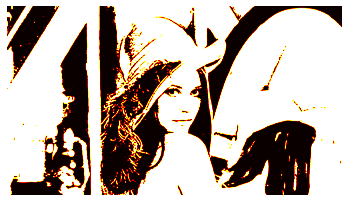

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
mybinary = get_filter0(gray,up=80)
print('my binary pic :')
plt.imshow(1 - mybinary,cmap=plt.cm.hot)
plt.axis("off")
plt.show()
print(mybinary)
del pic
del gray
del binary
del retval
del mat
del mybinary

---

### 1.1.2. 像素点到到坐标的转换矩阵


在处理图像的时候，我们做出如下假设：

- 连续性假设：假设提取的曲线都是中间连续不断的，或者仅有有限个间断点的曲线
- 平面假设：假设曲线图是完全二维的，也即再扫描过程中，扫描件为一个二维图形，没有因为书页的翘曲等因素向第三维发生翘曲、扭转等

对于平面的一个刚体，其有3个自由度。也就是定位一个平面位置，只需要确定三个点就可以了。我们现在应该有两个坐标：

1. 像素坐标：是由$i,j$定义的，每一个像素点所对应的坐标
2. 曲线坐标：是由$x,y$构成的，某一点在曲线坐标系下所对应的坐标位置

那么在平面上，必然会有两个坐标之间的一个转换关系，即：

$$
(x,y)=f(i,j)
$$

根据平面假设，这两个坐标之间的变换只会有：平移，旋转，仿射三种变换，在这样的假设下不难发现会有：

$$

\begin{bmatrix}
  x\\y
\end{bmatrix}

=

\begin{bmatrix}
  q_{11} & q_{21}\\
  q_{12} & q_{22}
\end{bmatrix}

\begin{bmatrix}
  i\\j
\end{bmatrix}

+

\begin{bmatrix}
  x_0\\y_0
\end{bmatrix}

$$

简记为：

$$
\boldsymbol{I}=\boldsymbol{Q} \boldsymbol{X} + \boldsymbol{X_0}
$$

这里把$\boldsymbol{Q}$成为转换矩阵，把$\boldsymbol{X_0}$称为转换零点坐标。如果点$(i_k,j_k)\rightarrow(x_k,y_k)$，那么有：

$$
\begin{cases}
i_k\cdot q_{11}+j_k\cdot q_{21}+x_0=x_k\\
i_k\cdot q_{12}+j_k\cdot q_{22}+x_0=y_k
\end{cases}
$$

因为刚体在平面上有三个自由度，所以需要$k=1,2,3$三组点到点的映射才能求解矩阵：

$$
\begin{cases}
(i_1,j_1)\rightarrow(x_1,y_1)\\
(i_2,j_2)\rightarrow(x_2,y_2)\\
(i_3,j_3)\rightarrow(x_3,y_3)
\end{cases}
$$

因此可以得到：

$$

\begin{bmatrix}
    i_1 & 0 & j_1 & 0 & 1 & 0\\
    0 & i_1 & 0 & j_1 & 0 & 1\\
    i_2 & 0 & j_2 & 0 & 1 & 0\\
    0 & i_2 & 0 & j_2 & 0 & 1\\
    i_3 & 0 & j_3 & 0 & 1 & 0\\
    0 & i_3 & 0 & j_3 & 0 & 1
\end{bmatrix}

\begin{bmatrix}
    q_{11}\\
    q_{12}\\
    q_{21}\\
    q_{22}\\
    x_0\\
    y_0
\end{bmatrix}

=

\begin{bmatrix}
    x_1\\
    y_2\\
    x_2\\
    y_2\\
    x_3\\
    y_3
\end{bmatrix}

\\
\downarrow
\\

\begin{bmatrix}
    q_{11}\\
    q_{12}\\
    q_{21}\\
    q_{22}\\
    x_0\\
    y_0
\end{bmatrix}

=

\begin{bmatrix}
    i_1 & 0 & j_1 & 0 & 1 & 0\\
    0 & i_1 & 0 & j_1 & 0 & 1\\
    i_2 & 0 & j_2 & 0 & 1 & 0\\
    0 & i_2 & 0 & j_2 & 0 & 1\\
    i_3 & 0 & j_3 & 0 & 1 & 0\\
    0 & i_3 & 0 & j_3 & 0 & 1
\end{bmatrix}
^{-1}

\begin{bmatrix}
    x_1\\
    y_1\\
    x_2\\
    y_2\\
    x_3\\
    y_3
\end{bmatrix}

$$

观察后容易发现可以化简,令：
$$

A=

\begin{bmatrix}
    i_1 & j_1 & 1\\
    i_2 & j_2 & 1\\
    i_3 & j_3 & 1
\end{bmatrix}

$$

则将上式化归为：
$$
A

\begin{bmatrix}
    q_{11}\\
    q_{21}\\
    x_0 
\end{bmatrix}

=

\begin{bmatrix}
    x_1\\
    x_2\\
    x_3 
\end{bmatrix}

\\
\\

A

\begin{bmatrix}
    q_{12}\\
    q_{22}\\
    y_0 
\end{bmatrix}

=
\begin{bmatrix}
    y_1\\
    y_2\\
    y_3 
\end{bmatrix}

$$

所以不难发现:

$$

\begin{bmatrix}
    q_{11}\\
    q_{21}\\
    x_0\\
    q_{12}\\
    q_{22}\\
    y_0
\end{bmatrix}

=

\begin{bmatrix}
    A^{-1} & 0\\
    0 & A^{-1}
\end{bmatrix}

\begin{bmatrix}
    x_1\\
    x_2\\
    x_3\\
    y_1\\
    y_2\\
    y_3
\end{bmatrix}

$$

于是在给定了三组点到点的映射情形下，可以解的此六个未知数，从而得到转换矩阵$
\boldsymbol{Q}$和转换零点坐标$\boldsymbol{X_0}$。不难发现，要保证$A$矩阵非奇异可逆，这三个点的选取也有要求；而且对于最终的转换关系，这三个点也有需求。因此姑且对这三个对应关系点的选取做如下要求：

- 选取的三个点不能在一条直线上，以保证$A$矩阵的非奇异性、可逆性
- 选取的三个点距离尽可能远，以更好的代表整幅画面的旋转、平移、仿射程度；一般选取坐标原点、坐标轴两端点作为三组对应的选取点

以下是转换矩阵与转换零点坐标的求解函数：

In [7]:
#转换矩阵函数，给定ij位置以及对应的xy坐标，返回转换矩阵q和转换零点坐标xy0
def Trans(ij,xy):
    i1 , j1 , i2 , j2 , i3 , j3 = ij
    x1 , y1 , x2 , y2 , x3 , y3 = xy
    A=np.array([
        [i1 , j1 , 1],
        [i2 , j2 , 1],
        [i3 , j3 , 1]
    ])
    invA = np.linalg.inv(A)
    q11,q21,x0 = invA.dot(np.array([x1 , x2 , x3]))
    q12,q22,y0 = invA.dot(np.array([y1 , y2 , y3]))
    q=np.array([
        [q11 , q21],
        [q12 , q22]
    ])
    xy0 = np.array([[x0] , [y0]])
    return q , xy0
    pass

---

## 1.2. 原点获取

我们以一张图为例子：

<div align="center"><img src="demo2.png" width="50%"></div>

按照之前的步骤我们进行一下预处理：

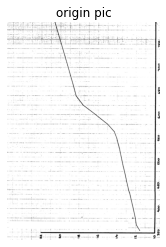

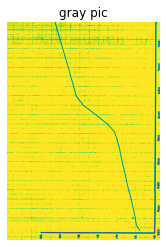

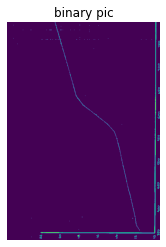

In [12]:
pic = cv.imread('demo2.png') #读取图片
plt.imshow(pic)
plt.axis('off')
plt.title('origin pic')
plt.show()

gray = cv.cvtColor(pic,cv.COLOR_BGR2GRAY) #灰度化
mat = np.array(gray)
plt.imshow(mat)
plt.axis('off')
plt.title('gray pic')
plt.show()

binary = get_filter0(mat , 10) #人工二值化
plt.imshow(binary)
plt.axis('off')
plt.title('binary pic')
plt.show()

要想获取原点坐标，有一个很朴素但有效的方法：

注意观察到原点有如下性质：

- 为两轴交点
- 一般而言扫描件图线是较为工整的，即使畸变，坐标轴所占据的像素宽度在三个左右

于是我们设计了一个算法将自动捕获在像素坐标系下的原点坐标$M_0,N_0$，其具体思路大致如下：

1. 新开一个矩阵Sum，其大小和二值化后的图像矩阵大小一致
2. 对于新开的矩阵Sum，其第 j 行第 i 列中填入某一值，该值计算方法如下
3. 将二值矩阵中 j-1、j、j+1行所有元素加起来，并加上，二值矩阵中 i-1、i、i+1列所有元素之和，填入Sum的 j 行 i 列
4. 搜寻Sum矩阵中最大值的位置，该位置 j , i 及对应的像素坐标系下的图线原点，记作 M0 ，N0

具体算法如下：

In [17]:
#自动筛选原点，传入灰度矩阵，返回M0，N0，和Sum矩阵
def get0(mat):
    M,N = np.shape(mat)
    Sum=np.zeros([M , N])
    for j in range(1,M-1):
        for i in range(1,N-1):
            Sum[j][i] = 0
            Sum[j][i]+= mat[j-1].sum()
            Sum[j][i]+= mat[j].sum()
            Sum[j][i]+= mat[j+1].sum()
            Sum[j][i]+= mat.T[i-1].sum()
            Sum[j][i]+= mat.T[i].sum()
            Sum[j][i]+= mat.T[i+1].sum()
            pass
        pass
    pos = np.argmax(Sum)
    M0 = int(pos / N)
    N0 = pos-N*M0
    return M0 , N0

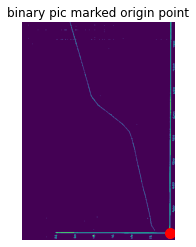

In [22]:
M0 , N0 = get0(binary)
plt.imshow(binary)
plt.axis('off')
plt.title('binary pic marked origin point')
plt.scatter(N0 , M0 , s=100 , color='r')
plt.show()


可以发现效果还是挺好的，直接定位到了原点的位置。

---

## 1.3. 图像过滤

因为图片品质的问题，往往会遇到一些点不能被二值化过滤掉形成极为难看的斑点，也会干扰最终的取点操作步骤。